In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess
from time import time


<h3>Steps to be followed</h3>
<ol>
    <li>Read in data</li>
    <li>Find starting and ending dates for train and test sets</li>
    <li>Create date range containing all dates from start to end of training set with hourly frequency</li>
    <li>Create a feature for time data with hourly frequency</li>
    <li>Create lag features</li>
</ol>

<h4>Reading Dataset</h4>

In [151]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train.date=pd.to_datetime(train.date)
test.date=pd.to_datetime(test.date)

<h4>Sorting train data by date and hour</h4>

In [152]:
train=train.sort_values(by=['date','hour'])
display(train.head())
print('train-shape: ',train.shape)
display(test.head())
print('test-shape: ',test.shape)

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


train-shape:  (18247, 3)


,date,hour
0,2021-03-01,0
1,2021-03-01,1
2,2021-03-01,2
3,2021-03-01,3
4,2021-03-01,5


test-shape:  (7650, 2)


<h4>Finding starting and ending dates for train and test sets</h4>

In [153]:
for title,df in [('Train',train),('Test',test)]:
    print(title+'\n'+'--'*30)
    print('Starting-date: ',df['date'].min())
    print('Ending-date: ',df['date'].max())
    print('\n')

Train
------------------------------------------------------------
Starting-date:  2018-08-18 00:00:00
Ending-date:  2021-02-28 00:00:00


Test
------------------------------------------------------------
Starting-date:  2021-03-01 00:00:00
Ending-date:  2022-03-28 00:00:00




In [154]:
# Generating hourly daterange for training data with hourly frequency
df1=pd.DataFrame({'combined_date':pd.date_range(start='2018-08-18',end='2021-02-28',freq='H')})

In [155]:
# merging hour column and datetime column
train['combined_date']=train.date.apply(lambda x:str(x))+' '+train.hour.apply(lambda x:str(x))+':00:00'
test['combined_date']=test.date.apply(lambda x:str(x))+' '+test.hour.apply(lambda x:str(x))+':00:00'

# converting new combined date column to datetime
train['combined_date']=pd.to_datetime(train['combined_date'])
test['combined_date']=pd.to_datetime(test['combined_date'])


In [156]:
# Merging df1 with train to get the full time index
df_train=pd.merge(df1,train,on='combined_date',how='left').drop(['date','hour'],axis=1).set_index('combined_date')
del(df1)

# filling NaN values with 0 since all missing timestamps can be assumed to have zero demand
df_train=df_train.fillna(0)

display(df_train.head())
print(df_train.shape)

,demand
combined_date,
2018-08-18 00:00:00,0.0
2018-08-18 01:00:00,0.0
2018-08-18 02:00:00,0.0
2018-08-18 03:00:00,0.0
2018-08-18 04:00:00,0.0


(22201, 1)


In [157]:
# creating a new time feature from the combined date column
dp=DeterministicProcess(index=df_train.index,
                       constant=False,
                       order=1,
                       drop=True)
df1=dp.in_sample().rename(columns={'trend':'time1'})
df_train=pd.merge(df1,df_train,on='combined_date',how='inner')
df_train.head()

,time1,demand
combined_date,,
2018-08-18 00:00:00,1.0,0.0
2018-08-18 01:00:00,2.0,0.0
2018-08-18 02:00:00,3.0,0.0
2018-08-18 03:00:00,4.0,0.0
2018-08-18 04:00:00,5.0,0.0


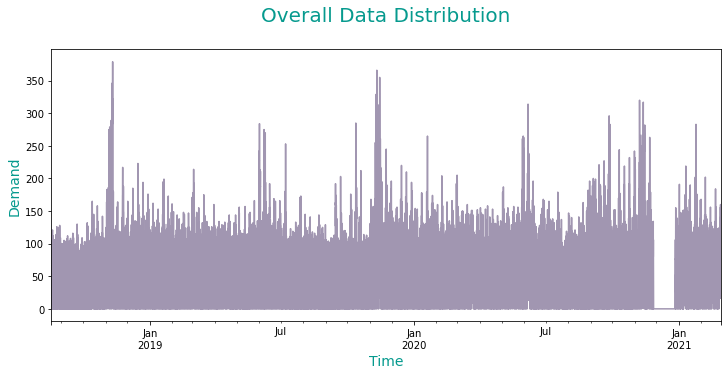

In [158]:
df_train['demand'].plot(figsize=(12,5),alpha=0.75,color='#827397')

# Setting title
plt.title('Overall Data Distribution\n',fontdict={'fontsize':20,'fontweight':5,'color':'#069A8E'})

# setting xlabels and ylabels
plt.xlabel('Time',fontdict={'fontsize':14,'fontweight':5,'color':'#069A8E'})
plt.ylabel('Demand',fontdict={'fontsize':14,'fontweight':5,'color':'#069A8E'});

It looks like data for the month of December,2020 is missing

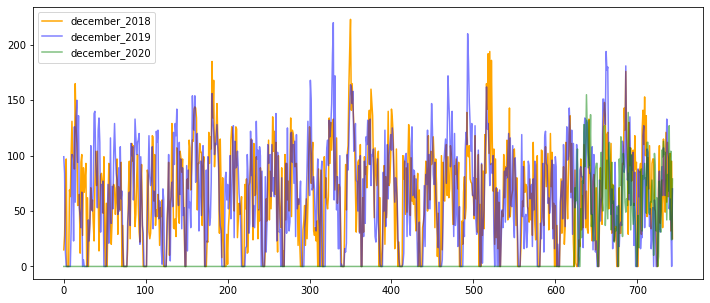

In [159]:
# Plotting data for december for 3 years
december_2018=df_train.loc[(df_train.index.year==2018) &(df_train.index.month==12)].reset_index()
december_2019=df_train.loc[(df_train.index.year==2019) &(df_train.index.month==12)].reset_index()
december_2020=df_train.loc[(df_train.index.year==2020) &(df_train.index.month==12)].reset_index()

december_2018['demand'].plot(figsize=(12,5),label='december_2018',color='orange')
december_2019['demand'].plot(figsize=(12,5),label='december_2019',color='blue',alpha=0.5)
december_2020['demand'].plot(figsize=(12,5),label='december_2020',color='green',alpha=0.5)


plt.legend();

December,2020 has missing data from 2020-12-01 to 2020-12-26. So these values will be replaced by average values from previous years

In [162]:
# Imputing missing values in december 2020 with average values from previous years

imputed_demand=0.5*(df_train.loc['2018-12-01':'2018-12-26','demand'].values+\
                    df_train.loc['2019-12-01':'2019-12-26','demand'].values)

df_train.loc['2020-12-01':'2020-12-26','demand']=imputed_demand

,time1,demand
combined_date,,
2020-12-01 00:00:00,20065.0,57.0
2020-12-01 01:00:00,20066.0,56.0
2020-12-01 02:00:00,20067.0,36.0
2020-12-01 03:00:00,20068.0,48.5
2020-12-01 04:00:00,20069.0,0.0
...,...,...
2020-12-26 19:00:00,20684.0,64.5
2020-12-26 20:00:00,20685.0,117.0
2020-12-26 21:00:00,20686.0,48.5


<AxesSubplot:xlabel='combined_date'>

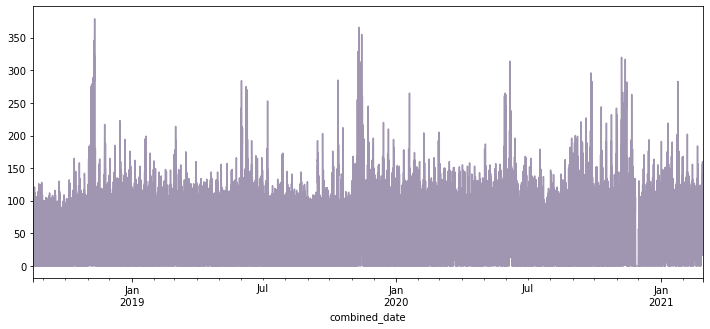

In [165]:
# Plotting the corrected data
df_train['demand'].plot(figsize=(12,5),alpha=0.75,color='#827397')

<h4>Creating Lag Features</h4>

In [171]:
def create_lag_features(df,col_names,n_lags=20):
    '''
    Creates lag_features from a list of features for a data frame
    
    Inputs
    ------------------------------
    df- the daataframe
    col_name--list of strings indicating column names from which features need to be created
    n_lags: number of lags to be created
    
    Outputs
    ------------------------------
    consolidated dataframe containing the lag features
    '''
    
    data=df.copy(deep=True)
    
    for col in col_names:
        for i in range(1,n_lags+1):
            data.loc[:,col+'_lag_'+str(i)]=data[col].shift(i)
    
    # fill NaN values with 0
    data.fillna(0,inplace=True)
    return data

<h4>Train-test-split</h4>
<p>
    Since the forecast needs to be made only for the month of March, test and validation sets will also be of 1 month each
</p>

In [183]:
df_train1=df_train.loc[:'2021-01-31']
X_test=df_train.loc['2021-02-01':]

print(X_train.shape)
print(X_test.shape)

(21552, 2)
(649, 2)


In [230]:
# creating lag features
df_train2=create_lag_features(df_train1,['demand'],n_lags=30)

# create validation_set
X_val=df_train2.loc['2021-01-01':'2021-01-31'].drop('demand',axis=1)
y_val=df_train2.loc['2021-01-01':'2021-01-31','demand']

# Create training set
X_train=df_train2.loc[:'2020-12-31'].drop('demand',axis=1)
y_train=df_train2.loc[:'2020-12-31','demand']

<h3>Model Building</h3>

<h4>Linear Model</h4>

In [272]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

In [231]:
lr_model=LinearRegression()

lr_model.fit(X_train,y_train)
pred=pd.Series(lr_model.predict(X_val),index=y_val.index)
rmse=np.sqrt(mean_squared_error(y_val,pred))
print('val_RMSE: ',rmse)

val_RMSE:  35.847363169506735


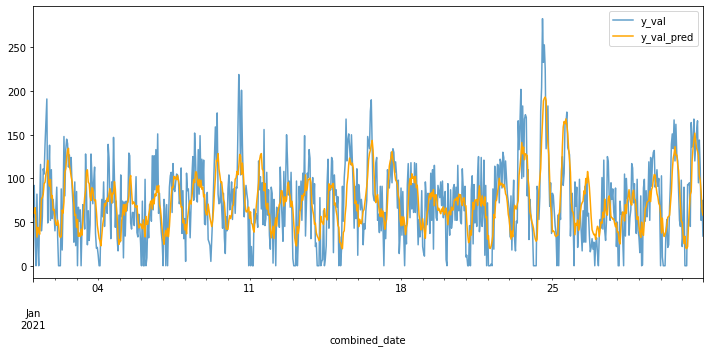

In [233]:
y_val.plot(figsize=(12,5),alpha=0.7,label='y_val');
pred.plot(alpha=1,color='orange',label='y_val_pred')
plt.legend();

<h4>XGBoost</h4>

In [234]:
from xgboost import XGBRegressor

In [273]:
start=time()
params = {
    "n_estimators":[100,500,1000],
     "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
     "max_depth" : [ 3, 5, 8, 10, 12, 15,20],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
        }


xgb_model = XGBRegressor()

# rs_model=BayesSearchCV(xgb_model,search_spaces=params,n_iter=50,
#                             scoring='neg_root_mean_squared_error',n_jobs=-1,cv=3,verbose=3)

rs_model=RandomizedSearchCV(xgb_model,param_distributions=params,n_iter=100,
                            scoring='neg_root_mean_squared_error',n_jobs=-1,cv=3,verbose=3)


rs_model.fit(X_train,y_train)
print(time()-start)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [270]:
rs_model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [271]:
pred=pd.Series(rs_model.predict(X_val),index=y_val.index)
rmse=np.sqrt(mean_squared_error(y_val,pred))
print(rmse)

35.548408511840876
